# **Air pollution data analysis**

---
Air pollution is a leading cause of death across the globe, and contributes to stroke, heart disease, lung cancer, and other respiratory illness. The goal of this project is to explore the air quality of the United Kingdom.

In this project, we are going to analyze different air pollutants from the air pollution data of different locations from UK and visualize the data to find trends.


**Data Source**

---
The air pollution data is taken from the [London Air](http://www.londonair.org.uk) website. The API provides data in two forms:


1.   By Site or location
2.   By pollutant species


**Air Quality Index**

---

The AQI is an index for reporting daily air quality. It tells you how clean or polluted your air is, and what associated health effects might be a concern for you. The higher the AQI value, the greater the level of air pollution and the greater the health concern. Smaller AQI means better air quality.

We are going to fetch the AQI for five major air pollutants:

1. Ozone
2. PM (Particle pollution or particulate matter)
3. NO2 (nitrogen dioxide)
4. NO (nitrogen monoxide)
5. FINE

We begin with installing the missing default modules for our project.

In [2]:
!pip install folium
!pip install ggplot
!pip install matplotlib

    100% |████████████████████████████████| 81kB 2.2MB/s 
  Running setup.py bdist_wheel for folium ... - \ done
  Stored in directory: /content/.cache/pip/wheels/f8/98/ff/954791afc47740d554f0d9e5885fa09dd60c2265d42578e665
Successfully built folium
    100% |████████████████████████████████| 2.2MB 6.3MB/s 


Once the required modules are installed, we start by importing all them to our project.

In [3]:
from datetime import datetime
import re

from bs4 import BeautifulSoup
import folium
from ggplot import *
import matplotlib.dates as md
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/usr/local/lib/python3.6/dist-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


To fetch the raw air pollution data, we are going to hit the [londonair](http://www.londonair.org.uk/london/asp/downloadsite.asp) API and fetch the required data. But before that, we shall get the info on cities listed [here](http://www.londonair.org.uk/london/asp/datadownload.asp) and store it in the city_info dictionary.

Note: We will use the python requests module to help fetch data and the BeautifulSoup to parse it.

In [0]:
# City Info URL
source_url = 'http://www.londonair.org.uk/london/asp/datadownload.asp'

# Fetch the list of cities supported by the API
raw_source_data = requests.get(source_url)

# Parse the response and get all the 'species1' option tags
tree = BeautifulSoup(raw_source_data.text, "html5lib")
select = tree.find("select", {"id":"species1"})
options = select.find_all("option")

# Store the result in the city_info dictionary with city_code as key and city_name as value
city_info = dict()
for option in options:
  
  # Exclude the cities whose data is no longer available
  if (not re.search(r'\(closed', option.text)) and (option.get('value')):
    city_info[option['value']] = option.text

Now that we have the city info, we will fetch the air pollution data for each of the cities (stored in the city_info dict) and create a new dictionary 'raw_data' with pollution data frames.

Note: This will take a long time as there are many cities to pull data for.

In [111]:
# Air pollution data source api
base_data_url = 'http://www.londonair.org.uk/london/asp/downloadsite.asp'

# Add the pollutant details in the query string of the above url
species_query_string = 'species1=NO2m&species2=NOXm&species3=O3m&species4=PM10m&species5=FINE&species6=PM25m'

sns.set(style="white", context="talk")

# Helper method to parse string dates and convert them to datetime objects
def convert_to_datetime(df):
  df.ReadingDateTime = pd.to_datetime(pd.Series(df.ReadingDateTime))
  
# Fetch and store data for each city in the raw_data dictionary.
raw_data = dict()

print('Downloading data', end='')
for city_code in city_info:
  print('.', end='')
  
  # Adding start and end dates and create the final data url to start data pull
  data_url = '{}?site={}&{}&start=1-jan-2015&end=1-jan-2018&res=6&period=daily&units=ugm3'.format(base_data_url, city_code, species_query_string)
  
  # Response is a csv file, so we directly read it using panda's read_csv method
  city_data = pd.read_csv(data_url)
  convert_to_datetime(city_data)
  raw_data[city_code] = city_data

Before we begin analyzing and visualizing data, we will take a look at the way the data is currently stored. The code below shows the records from the dataframe of city with the code 'CT4' (which is City of London - Beech Street location).

The dataframe has 6 columns:


1.   Site - Location from any of the cities from UK
2.   Species - Pollutant name
3.   ReadingDateTime - Timestamp at which the data was recorded
4.   Value - Recorded pollution value
5.   Units - Units of measurement of the pollutant
6.   Provisional or Ratified - Flag which tells if the record is provisional or ratified.



In [38]:
print(city_info['CT4'])
raw_data['CT4'].head()

City of London - Beech Street


,Site,Species,ReadingDateTime,Value,Units,Provisional or Ratified
0,CT4,NO2,2015-01-01,34.6,ug m-3,R
1,CT4,NO2,2015-02-01,65.8,ug m-3,R
2,CT4,NO2,2015-03-01,73.1,ug m-3,R
3,CT4,NO2,2015-04-01,68.2,ug m-3,R
4,CT4,NO2,2015-05-01,80.6,ug m-3,R


To analyze the data effectively, we calculate the overall AQI as the maximum AQI among all the pollutants.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5,1,'Figure 1. City vs Overall AQI')

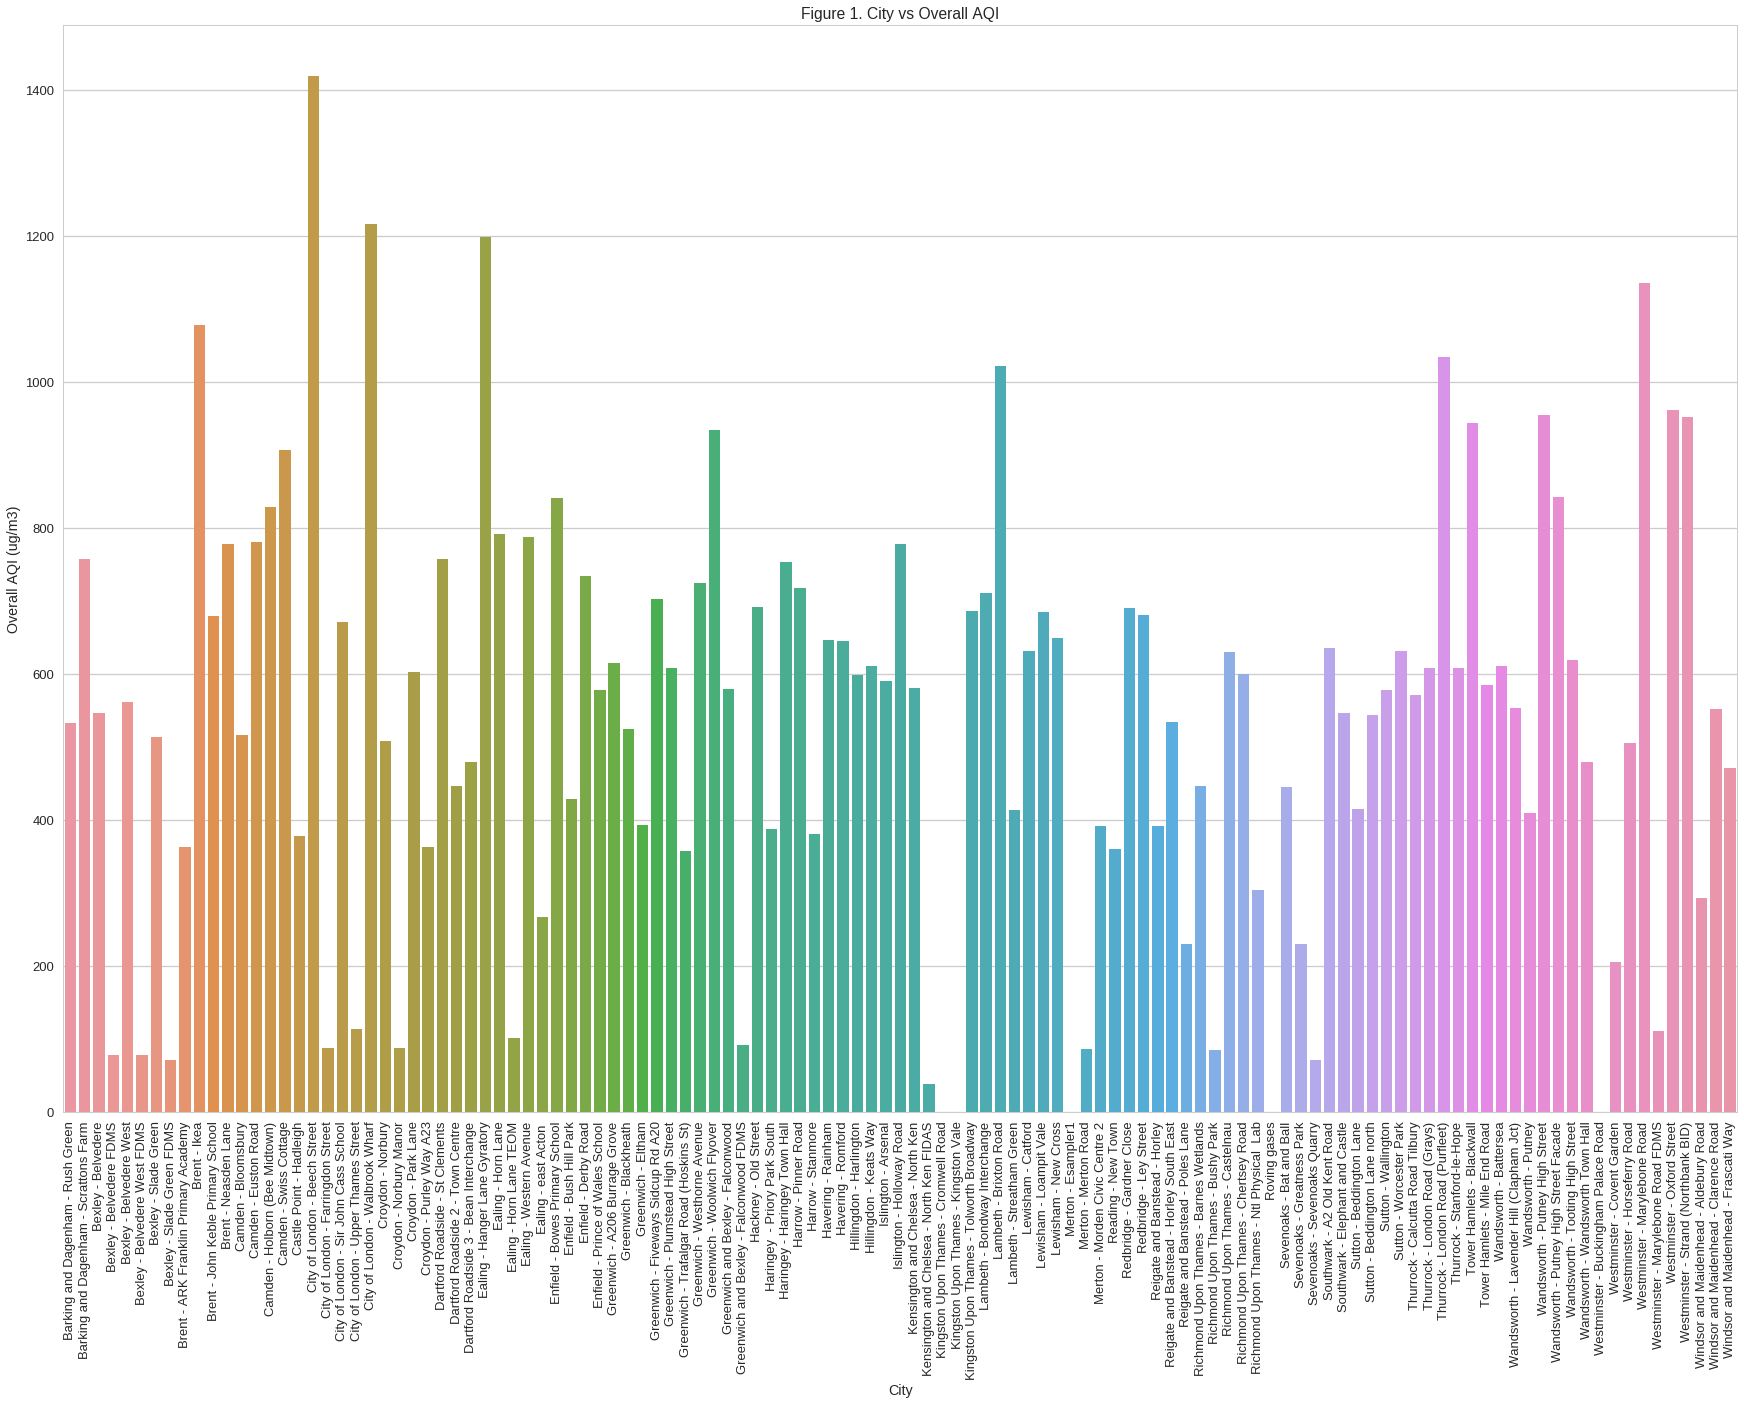

In [114]:
# Track figure count
FIG_COUNT = 0

def get_fig_num():
  global FIG_COUNT
  FIG_COUNT += 1
  return FIG_COUNT

# Create an empty dataframe to store the overall AQI per city
max_values = pd.DataFrame()


for key in raw_data:
  df = raw_data[key]
  max_row = df[df.Value == df.Value.max()]
  max_row['City'] = [city_info[key]]
  max_values = max_values.append(max_row, ignore_index=True)
 
a4_dims = (30, 20)
fig, ax = plt.subplots(figsize=a4_dims)
sns.set_style("whitegrid")
ax = sns.barplot(x="City", y="Value", data=max_values, ax=ax)
ax.set(xlabel='City', ylabel='Overall AQI (ug/m3)')
loc, labels = plt.xticks()
ax.set_xticklabels(labels, rotation=90)
plt.title('Figure {}. City vs Overall AQI'.format(get_fig_num()))

Figure 1 is a plot of city location vs the overall AQI (max pollutant) value. We can clearly see that the average AQI value for the all these locations ranges from 400-800. We can confirm this by plotting a frequency distribution plot. (Figure 2). The plot shows that there are about 30 locations with AQI 600.

Text(0.5,1,'Fig 2. Frequence distribution plot')

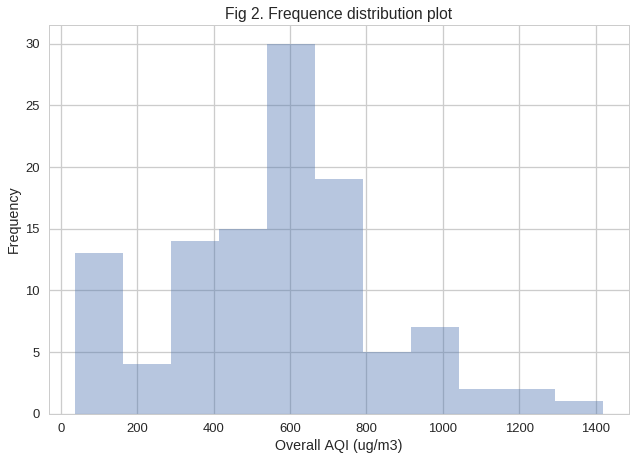

In [69]:
# Remove null values and plot the frequency distribution plot
ax = sns.distplot(max_values[max_values.Value.notnull()].groupby('City', as_index=False).Value.max().Value, kde=False)
ax.set(xlabel='Overall AQI (ug/m3)', ylabel='Frequency')

plt.title('Fig {}. Frequence distribution plot'.format(get_fig_num()))

From the figures above, top 3  most polluted cities are:
1. City of London (CT)
2. Ealing (EA)
3. Westminster (WM)

Let us now analyze pollutation data for these cities in detail one by one.

In this section, we are going to plot month AQI value for each of the pollutant per location. We start by getting the list of sites(city codes) for each of the above locations and plot a line graph of the monthly AQI value for each pollutant.

**City of London**

---


Figure 3 shows a lineplot of the monthly AQI data (aggregated) for each of the pollutants. From the plot, we can infer that the main cause of pollution for all the streets in london is 'NOX' (highest range of AQI values).

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


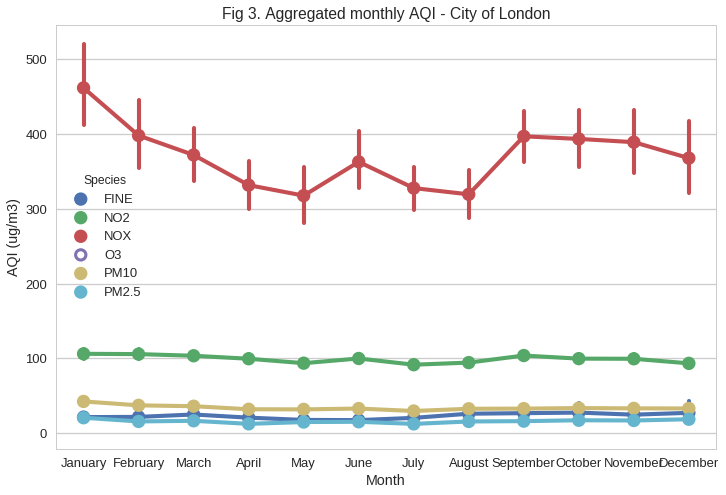

In [70]:
# Helper method to get the list of city codes for each of the city name
def get_city_codes(city_name):
  city_codes = []
  
  regex = r'^{}'.format(city_name)
  
  # Filter and get all the city codes for the given city name
  for city_code in city_info:
    if re.search(regex, city_info[city_code]):
      city_codes.append(city_code)
  return city_codes

# Helper method which aggregates data on pollutant species and datetime. Also adds a new month column and returns the max aggregated data
def aggregate_city_data(city_codes):
  agg_data = pd.concat(list(map(lambda x: raw_data[x], city_codes))).groupby(['Species', 'ReadingDateTime'], as_index=False)['Value'].max()
  agg_data['Month'] = agg_data['ReadingDateTime'].dt.strftime('%B')
  return agg_data

# Method to plot line/point graph on month and AQI
def plot_monthly_pollution_data(city_codes, city_name):
  ax = sns.pointplot(data=aggregate_city_data(city_codes), x='Month', y='Value', hue='Species')
  ax.set(xlabel='Month', ylabel='AQI (ug/m3)')
  plt.title('Fig {}. Aggregated monthly AQI - {}'.format(get_fig_num(), city_name))
  plt.tight_layout()
  
# Method to draw box plot of each pollutant from the aggregated city data
def plot_box(city_codes, city_name):
  ax = sns.boxplot(
    x='Value',
    y='Species',
    data=aggregate_city_data(city_codes)
  )
  ax.set(xlabel='AQI (ug/m3)', ylabel='Pollutant')
  plt.title('Fig {}. Box plot of AQI values for all pollutants - {}'.format(get_fig_num(), city_name))
  
london_city_codes = get_city_codes('City of London')
  
plot_monthly_pollution_data(london_city_codes, 'City of London')


Let us take a look at how the aggregated data looks like:

In [71]:
aggregate_city_data(london_city_codes).head()

,Species,ReadingDateTime,Value,Month
0,FINE,2015-01-01,21.9,January
1,FINE,2015-01-02,9.4,January
2,FINE,2015-01-03,15.4,January
3,FINE,2015-01-04,21.4,January
4,FINE,2015-01-05,14.1,January


To analyze further, we can also plot the distribution of aggregated data for each of the pollutant for the city (Figure 4). The same conclusion can be drawn from the box plot and we also note that for most of days, the AQI value of the main pollutant (NOX compounds) lies in the range of 220-500. It goes as high as 1400 and low as 50 (approx). Similar conclusions can be drawn for the other pollutants.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


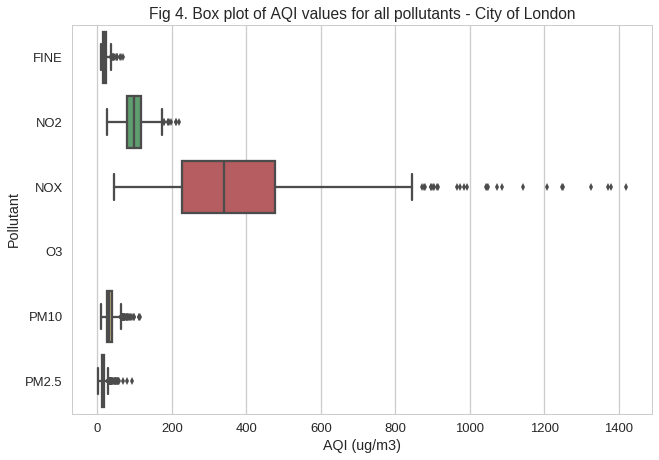

In [72]:
plot_box(london_city_codes, 'City of London')

We can summarize all the above observations in a facediagram as shown in the Fig 5. Some additional observations that we can make from this summary plot is that the pollution is max in January followed by November and it is least in July and april.

In [0]:
# Method to plot bar graphs for each location of the city and the pollutant
def plot_subplots(city_codes):
  fig, axarr = plt.subplots(3, len(city_codes), figsize=(30, 30))

  for idx, city_code in enumerate(city_codes):
    no2_data = raw_data[city_code][raw_data[city_code].Species == 'NO2']
    no2_data.groupby(no2_data['ReadingDateTime'].dt.strftime('%B')).Value.max().plot.bar(
      ax=axarr[0][idx], fontsize=12
    )

    axarr[0][idx].set_title('{} - NO2'.format(city_info[city_code]))
    axarr[0][idx].set_xlabel('Month')

    no_data = raw_data[city_code][raw_data[city_code].Species == 'NOX']
    no_data.groupby(no_data['ReadingDateTime'].dt.strftime('%B')).Value.max().plot.bar(
      ax=axarr[1][idx], fontsize=12
    )

    axarr[1][idx].set_title('{} - NO'.format(city_info[city_code]))
    axarr[1][idx].set_xlabel('Month')

    pm10_data = raw_data[city_code][raw_data[city_code].Species == 'PM10']
    pm10_data.groupby(pm10_data['ReadingDateTime'].dt.strftime('%B')).Value.max().plot.bar(
      ax=axarr[2][idx], fontsize=12
    )

    axarr[2][idx].set_title('{} - PM10'.format(city_info[city_code]))
    axarr[2][idx].set_xlabel('Month')
    
  plt.tight_layout()
    
  plt.suptitle('Fig {}. Summary facetgraph'.format(get_fig_num()))


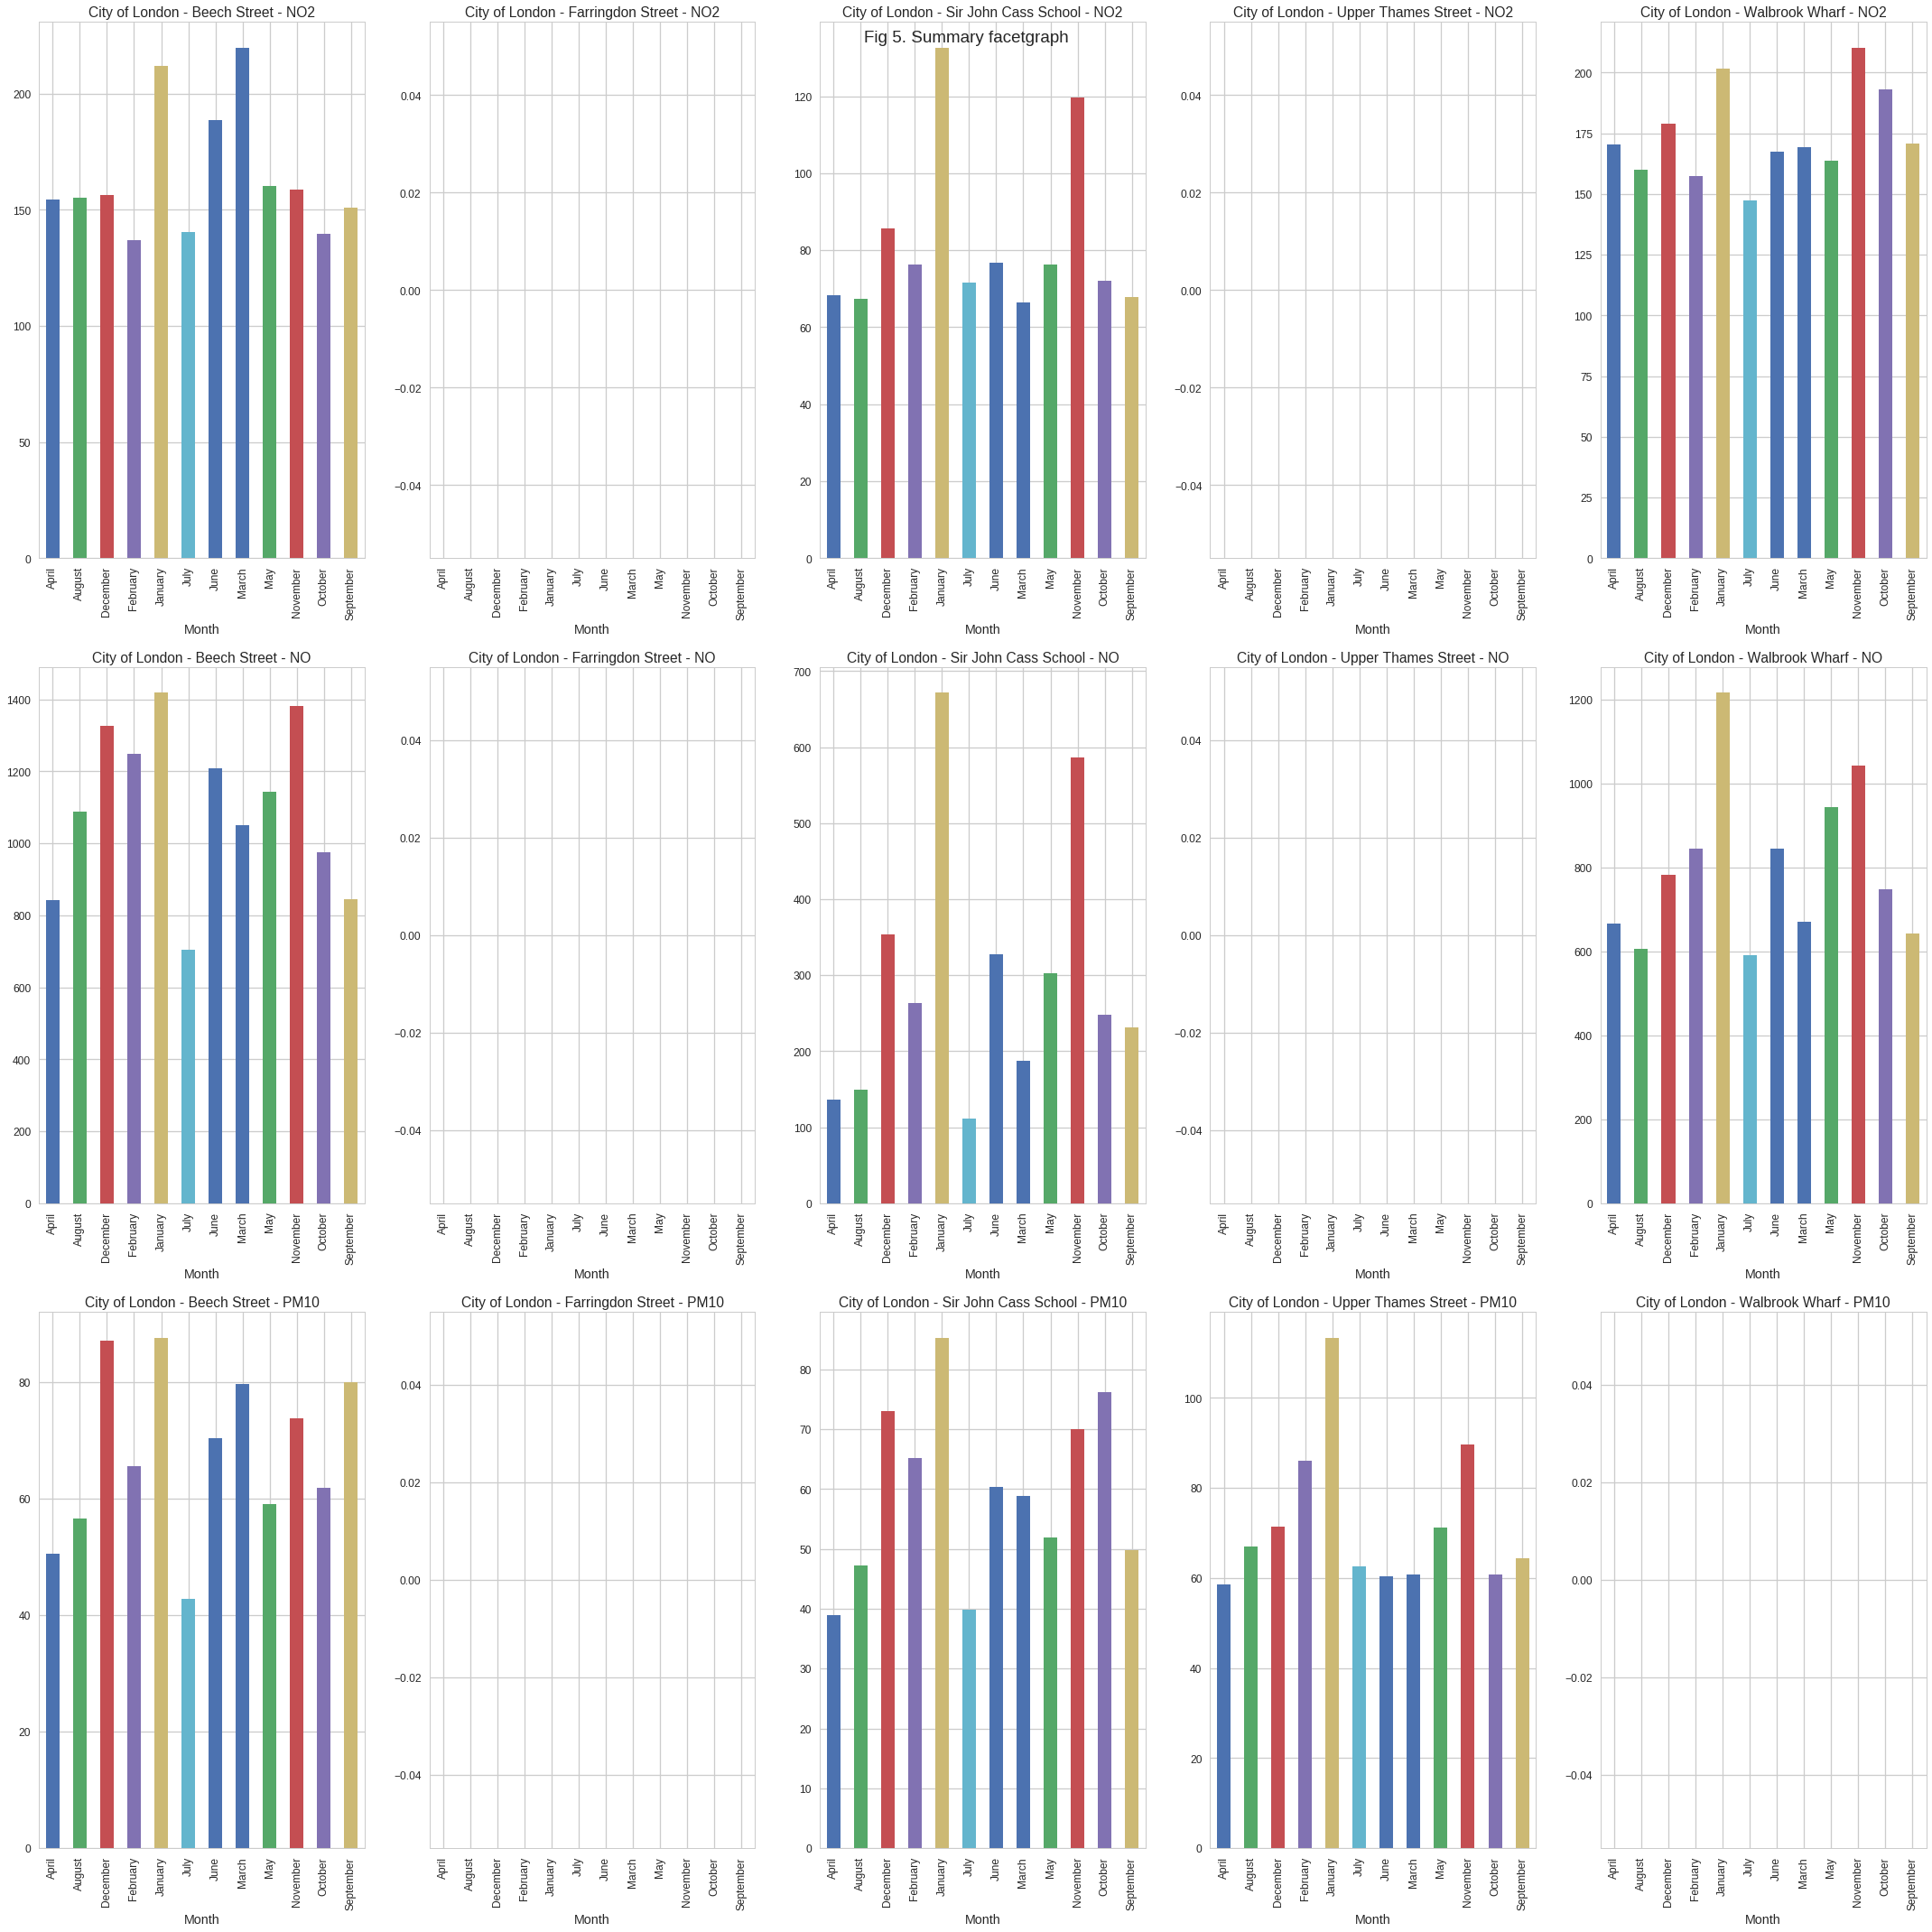

In [74]:
plot_subplots(london_city_codes)



A similar set of plots can be draw for the other two most polluted cities of london, i.e Ealing (EA) and Westminster (WM).

**Ealing (EA)**

---


Figure 6 shows a lineplot of the monthly AQI data (aggregated) for each of the pollutants. Again, the main cause of pollution are the compounds of NOX as seen from the graph below. However it is interesting to note that, the AQI values for each of the pollutants is much lower than the locations from the city of London.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


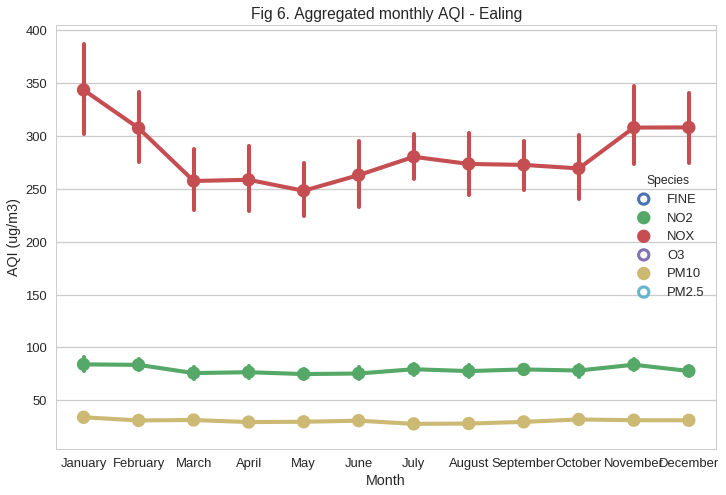

In [75]:
ealing_codes = get_city_codes('Ealing')
  
plot_monthly_pollution_data(ealing_codes, 'Ealing')

Now we shall plot the distribution of aggregated data for each of the pollutant from Ealing city (Figure 7). Here, the AQI values range for each of the pollutants in much lesser than that from city of London. The AQI value of the main pollutant (NOX compounds) lies in the range of 160-360. It goes as high as 1200 and low as 30 (approx). Similar conclusions can be drawn for the other pollutants.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


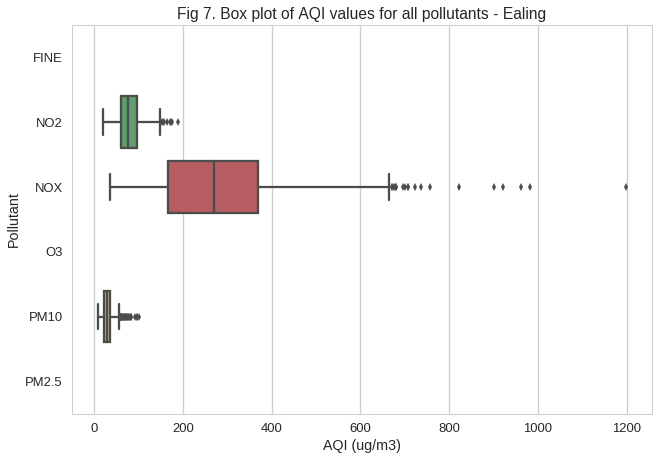

In [78]:
plot_box(ealing_codes, 'Ealing')

Fig 8 shows the summary Facetdiagram for Ealing city with similar conclusions drawn that the locations are max polluted in January and least in July.

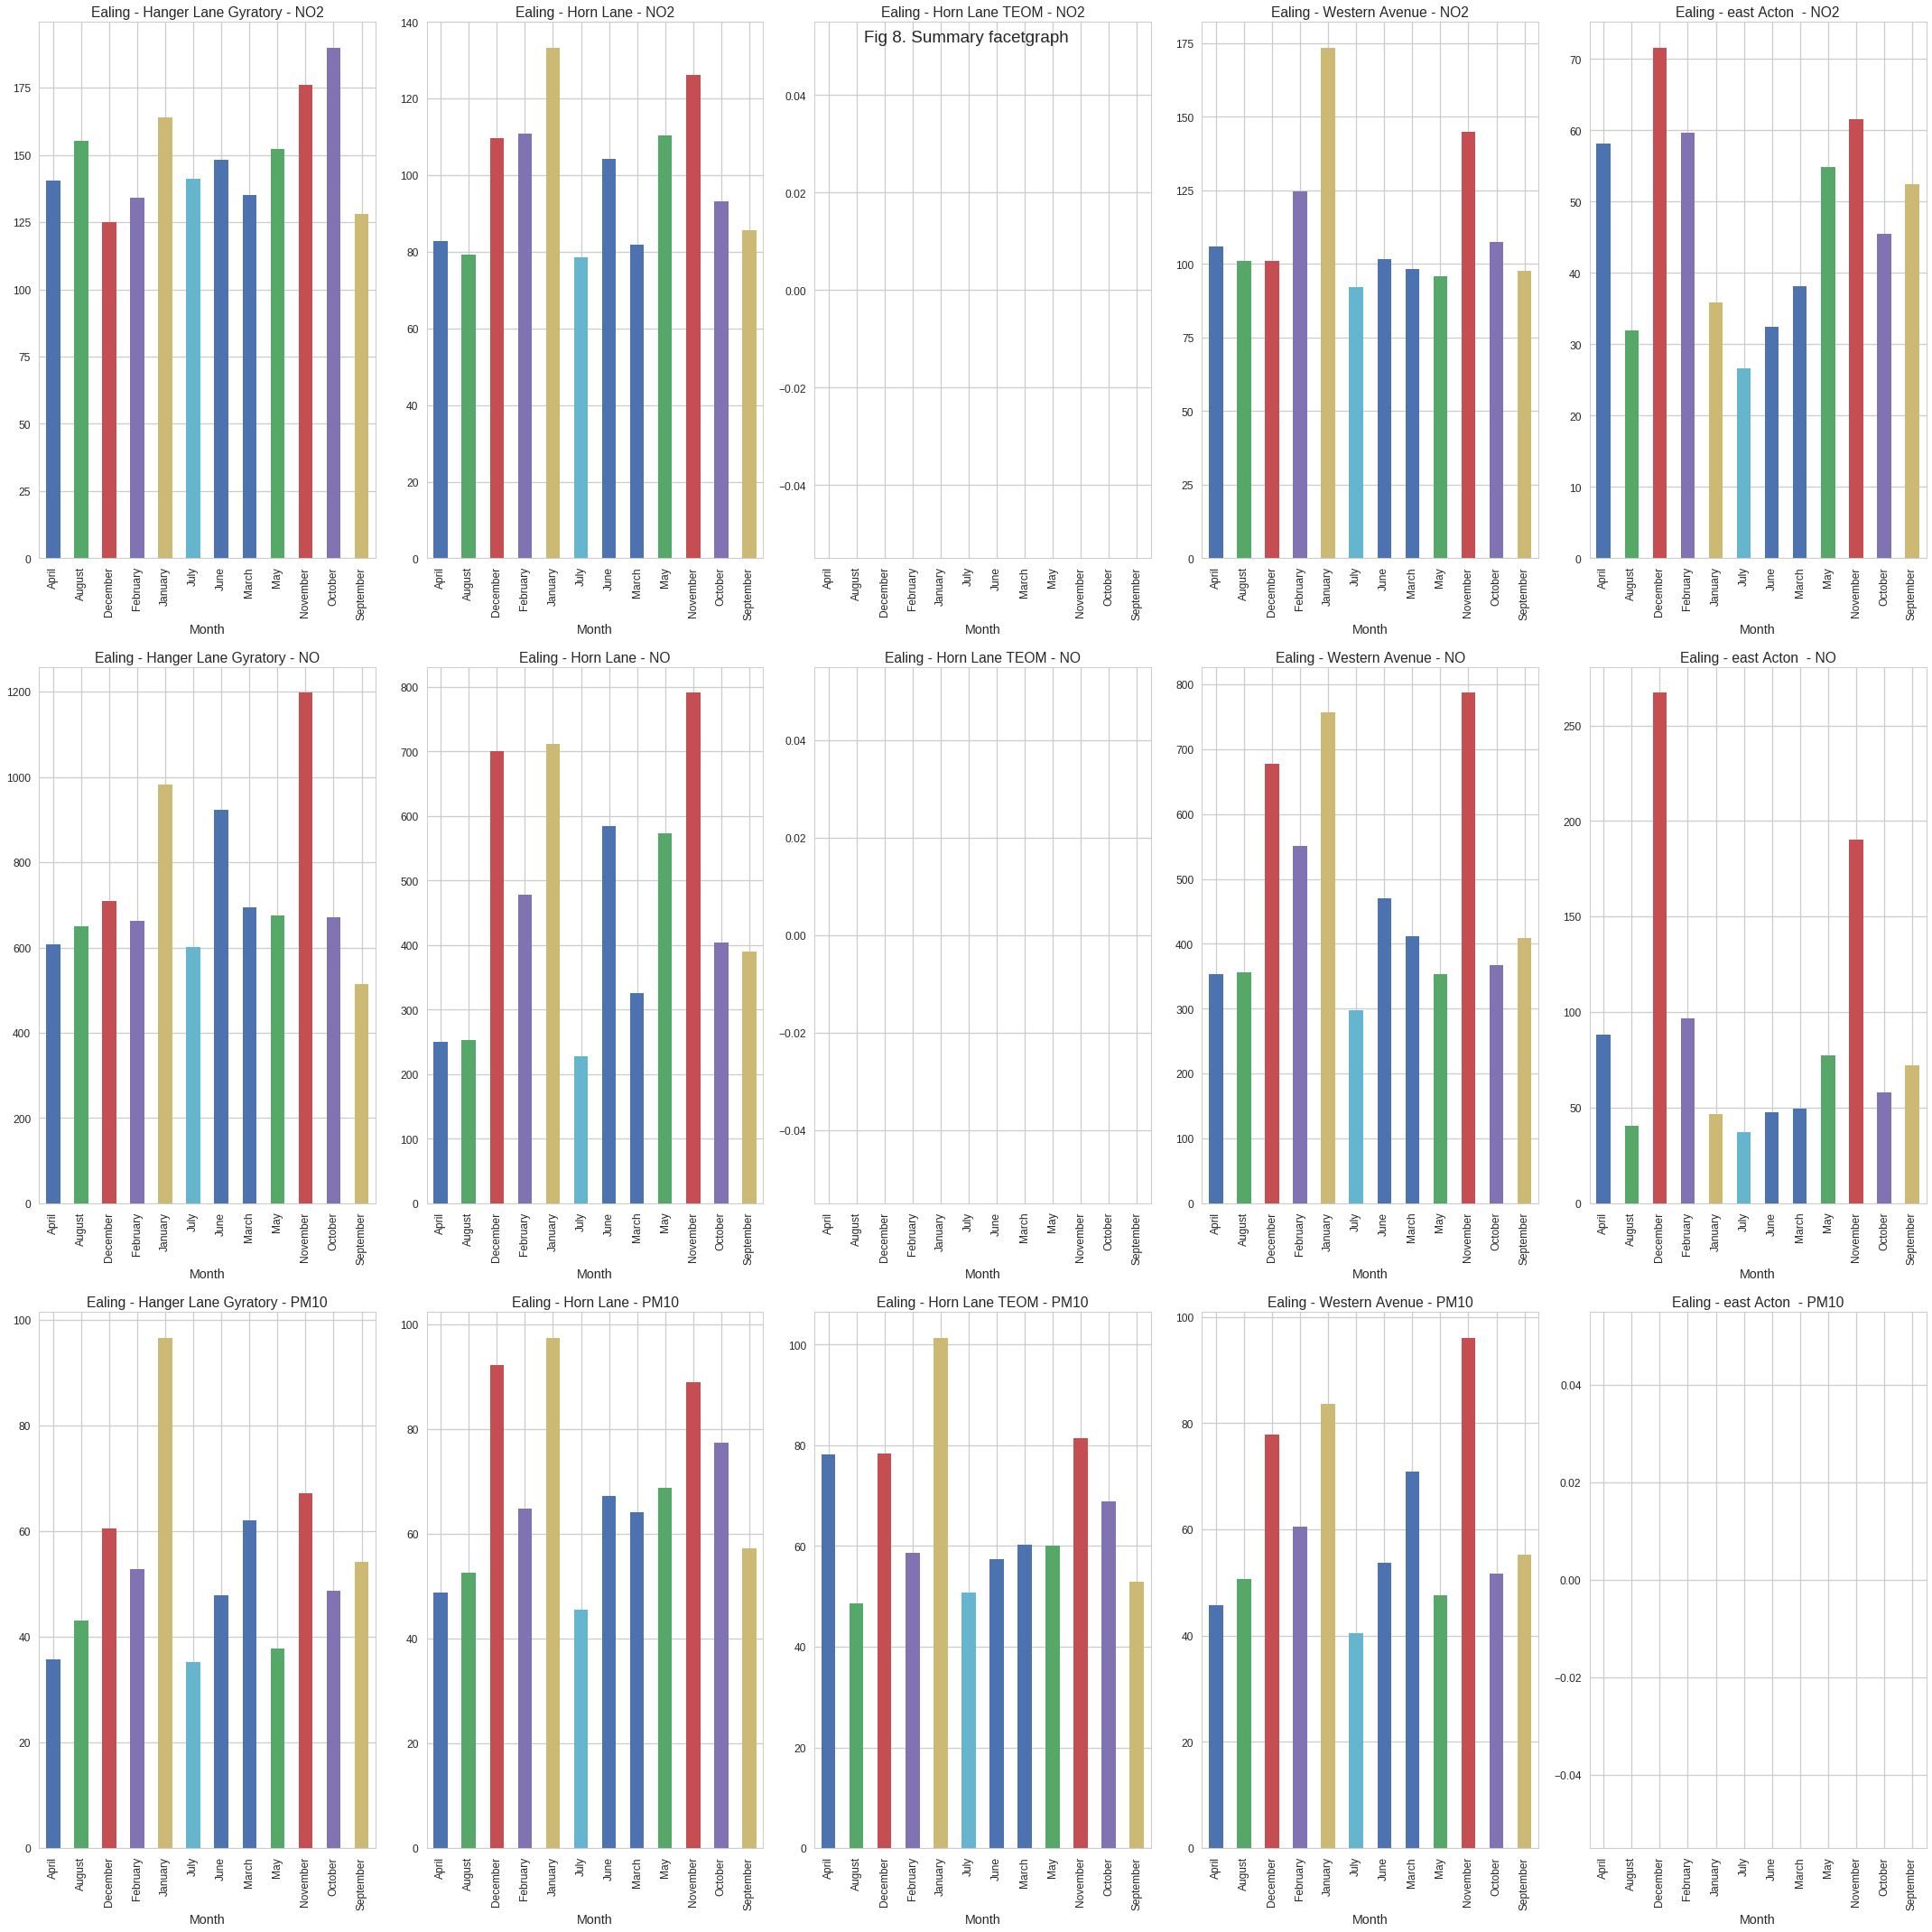

In [80]:
ealing_codes = get_city_codes('Ealing')
plot_subplots(ealing_codes)

**Westminster (WM)**

---


Figures 9, 10 and 11 show a lineplot, boxplot and summary facet graphs from the city of Westminster respectively.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


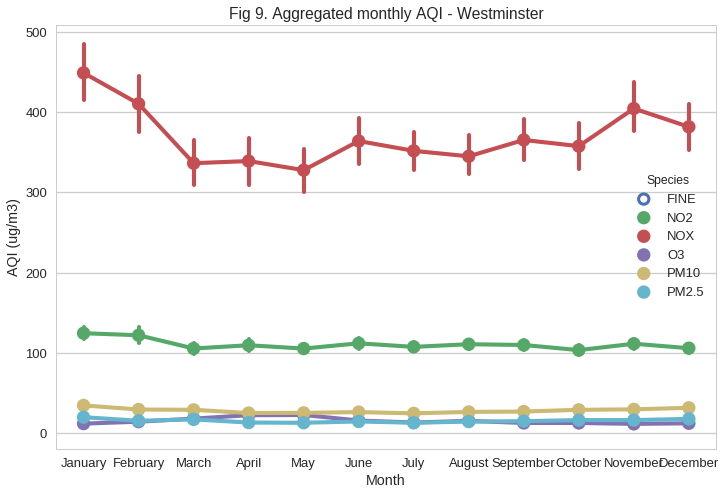

In [81]:
westminster_codes = get_city_codes('Westminster')
  
plot_monthly_pollution_data(westminster_codes, 'Westminster')

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


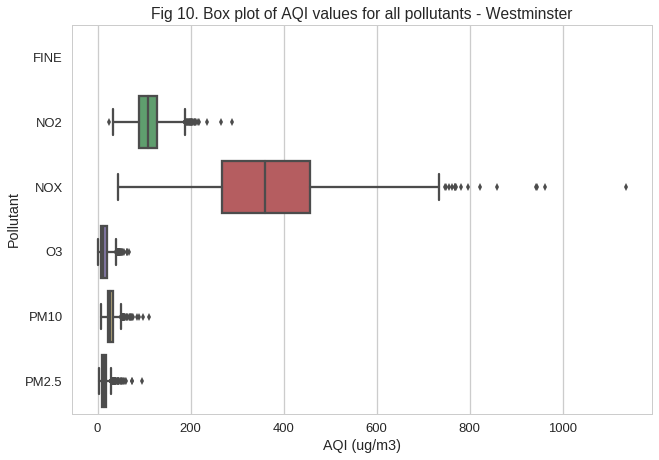

In [82]:
plot_box(westminster_codes, 'Westminster')

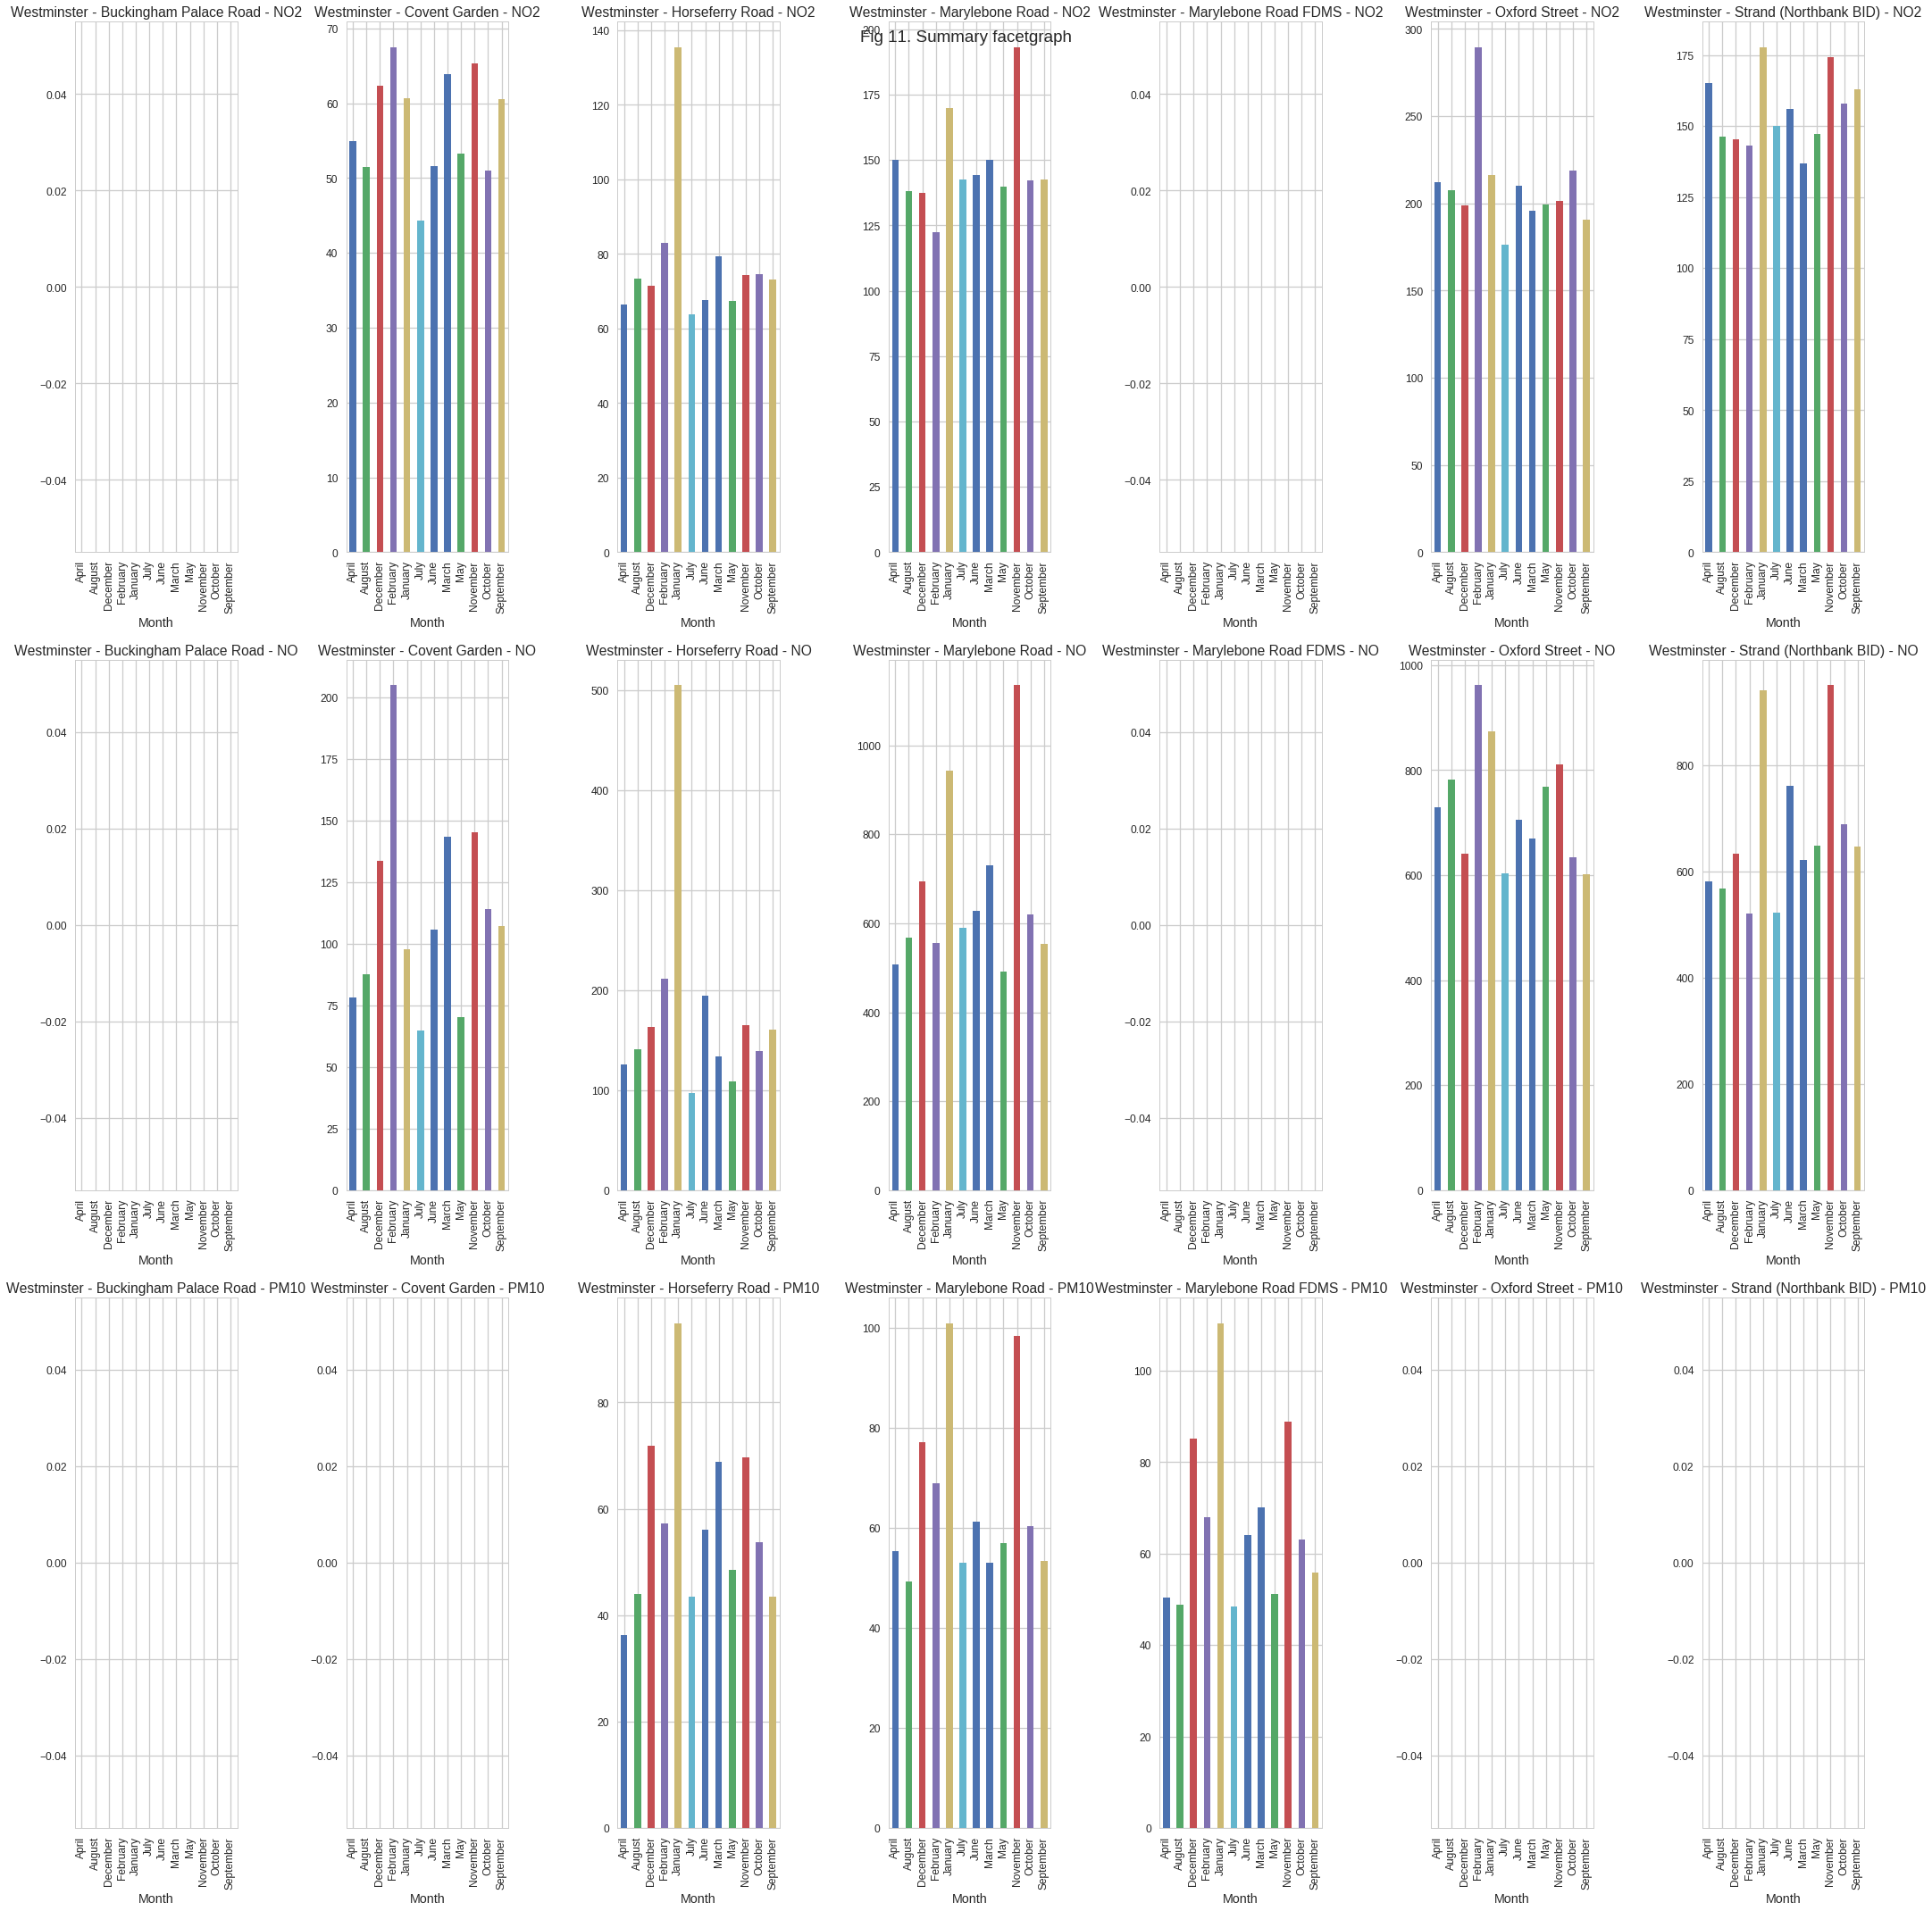

In [83]:
plot_subplots(westminster_codes)

We will now look at the yearly trends of the pollution data.

We start off by merging the dataframes of all the location into one large dataframe called full_df. A glimpse of the merged data can be seen from the dataframe table below.

In [85]:
# Helper method that merges data from all the dataframes. Also adds the month and year columns.
def get_merged_all_data():
  df = pd.DataFrame()
  for city_code in raw_data:
    raw_data[city_code]['Month'] = raw_data[city_code]['ReadingDateTime'].dt.month
    raw_data[city_code]['Year'] = raw_data[city_code]['ReadingDateTime'].dt.year
    df = df.append(raw_data[city_code], ignore_index=True)
    return df
  
full_df = get_merged_all_data()
full_df.head()


,Site,Species,ReadingDateTime,Value,Units,Provisional or Ratified,Month,Year
0,BG1,NO2,2015-01-01,NaN,ug m-3,R,1,2015
1,BG1,NO2,2015-02-01,NaN,ug m-3,R,2,2015
2,BG1,NO2,2015-03-01,26.5,ug m-3,R,3,2015
3,BG1,NO2,2015-04-01,37.0,ug m-3,R,4,2015
4,BG1,NO2,2015-05-01,30.1,ug m-3,R,5,2015


We now visualize the yearly trends by plotting a line graph as shown in Fig 12. It is to be noted that the AQI values are averaged for plotting purpose.

As we can see from the graph below, the AQI value is increasing every year at an alarming rate especially due to NOX compunds.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


Text(0.5,1,'Fig 12. Yearly AQI trends plot')

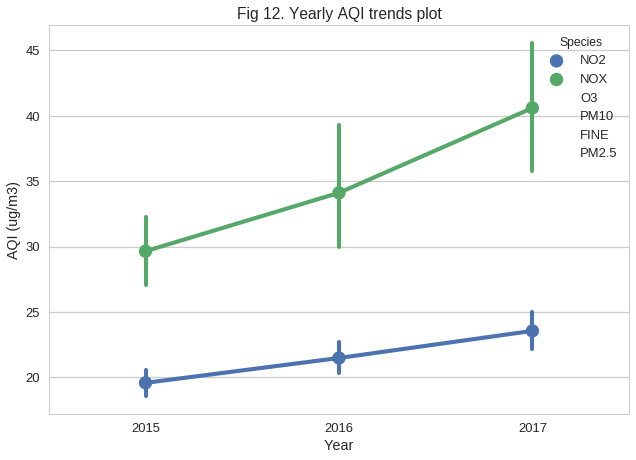

In [108]:
ax = sns.pointplot(data=full_df, x='Year', y='Value', hue='Species')
ax.set(xlabel='Year', ylabel='Mean AQI (ug/m3)')
plt.title('Fig {}. Yearly AQI trends plot'.format(get_fig_num()))

We conclude by plotting a swarmplot using seaborn as shown in Fig 13. The frequency and the mean AQI values are increasing year by year which has to be taken care.

Text(0.5,1,'Fig 13. Yearly AQI trends plot')

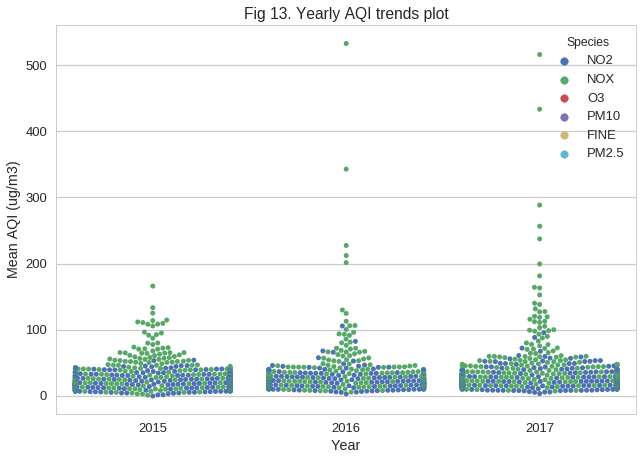

In [109]:
ax = sns.swarmplot(x="Year", y="Value", hue="Species", data=full_df)
ax.set(xlabel='Year', ylabel='Mean AQI (ug/m3)')
plt.title('Fig {}. Yearly AQI trends plot'.format(get_fig_num()))